In [1]:
import os
import time

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import rpy2
from rpy2.robjects import numpy2ri
from rpy2.robjects import pandas2ri
numpy2ri.activate()
pandas2ri.activate()

from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc
from sklearn.metrics import roc_curve

import pims
from tqdm.auto import tqdm

from lib import detection
from lib import analysis

# Classifier V3.0: A New Hope??

We have a whole new set of cells. Let's sample puffs from each of those cells to build a training dataset. Ideally, I will have sampled randomly and have an equal number of cells from each condition. In reality, here's what condition_checker tells me:

```
condition_checker.py ~/UM\ Drive/OPP/OPP_scramble.log 0IYVHRNA.tif 19CC75ZU.tif 2TZWB6CN.tif 3W70AV4V.tif 3WE2GUYC.tif 42GSRFR0.tif 53BFW81Q.tif 56CCWWJI.tif 5FWR8G3N.tif 5RTVNBXU.tif 6SG3YVW7.tif 79NWKD4H.tif 7C4SV01F.tif 7XFW332I.tif 7XGJBQQ3.tif 7YFIHF8P.tif 8C92MS0M.tif 9VEA7WGA.tif
3 B2 cells, 8 MOR cells, 7 TfR Cells
```

So that's not...GREAT. But it's a start for a classifier. So, how do we do this?

## Sample Selection

Let's evaluate each of the cells that have been scored so far and find out the frequency of puffs and total number of puffs in those cells:

In [2]:
basedir = '/Volumes/Coatamer/Users/weinberz/UM Drive/OPP'
files = os.listdir(basedir)
tifs = [tif for tif in files if 'tif' in tif]
xmls = [xml for xml in files if 'xml' in xml]
movie_info = {}
for tif in tifs:
    movie_name = tif.split('.')[0]
    matches = [xml for xml in xmls if movie_name in xml]
    if matches:
        movie_info[movie_name] = {'tif' : tif,
                                  'xml' : matches[0]}

In [9]:
for movie in movie_info:
    events = pd.read_csv('data/'+movie+'.tif_events.csv', index_col=False)
    marker_locs = detection.import_xml_data(basedir + os.sep + movie_info[movie]['xml'])
    puff_ids = np.array([detection.filter_df(events, m, 5) for m in marker_locs])
    print('%d puffs in %d events (%.4f puff rate)' % (len(np.unique(puff_ids[puff_ids>0])),
                                                      len(np.unique(events['particle'])),
                                                      (len(np.unique(puff_ids[puff_ids>0]))/len(np.unique(events['particle'])))))

35 puffs in 6090 events (0.0057 puff rate)
370 puffs in 8716 events (0.0425 puff rate)
55 puffs in 5149 events (0.0107 puff rate)
65 puffs in 9588 events (0.0068 puff rate)
488 puffs in 9346 events (0.0522 puff rate)
62 puffs in 8909 events (0.0070 puff rate)
509 puffs in 10202 events (0.0499 puff rate)
71 puffs in 6002 events (0.0118 puff rate)
108 puffs in 10202 events (0.0106 puff rate)
37 puffs in 9594 events (0.0039 puff rate)
482 puffs in 7765 events (0.0621 puff rate)
34 puffs in 3511 events (0.0097 puff rate)
254 puffs in 10725 events (0.0237 puff rate)
266 puffs in 6732 events (0.0395 puff rate)
72 puffs in 7732 events (0.0093 puff rate)
16 puffs in 4843 events (0.0033 puff rate)
604 puffs in 8056 events (0.0750 puff rate)
183 puffs in 3715 events (0.0493 puff rate)


That's a large range, but overall a small enough number of a events to be able to try training a clasffiier on all cells! Let's load in the features calculated for all these events:

In [12]:
features_list = []
for movie in tqdm(list(movie_info.keys())):
    intensities = pd.read_csv('data/' + movie + ".tif_intensities.csv", index_col=0)
    puff_ids_to_sample = intensities.loc[intensities['puff']==1,'particle'].values
    features = pd.read_csv('data/' + movie + ".tif_featuress.csv", index_col=0)
    features.loc[:, 'cell'] = movie
    features.loc[:, 'puff'] = features['particle'].isin(puff_ids_to_sample).astype(int)
    features_list.append(features)
    
labeled_sample = pd.concat(features_list, ignore_index=True)

In [13]:
print('%d puffs in %d events (%.4f puff rate)' % (np.sum(labeled_sample['puff']),
                                                  np.shape(labeled_sample)[0],
                                                  (np.sum(labeled_sample['puff'])/np.shape(labeled_sample)[0])))

3711 puffs in 136877 events (0.0271 puff rate)


This enrichment is at about the rate that we had seen previously with the 10Hz movies, which we were able to (in some cases) detect events. Cool! Let's try it!

## Classifier

With a puff sample detected, we can now generate a classifier trained on it. The following is the evaluated OOB sample on a calssifier train on all of the data. For this, we're using all of the cross-correlation features that Ciaran generated, as well as area and perimeter of the convex hull, plus event lifetime, total change in fluorescence over event lifetime, and time to reach half-max after maximum.

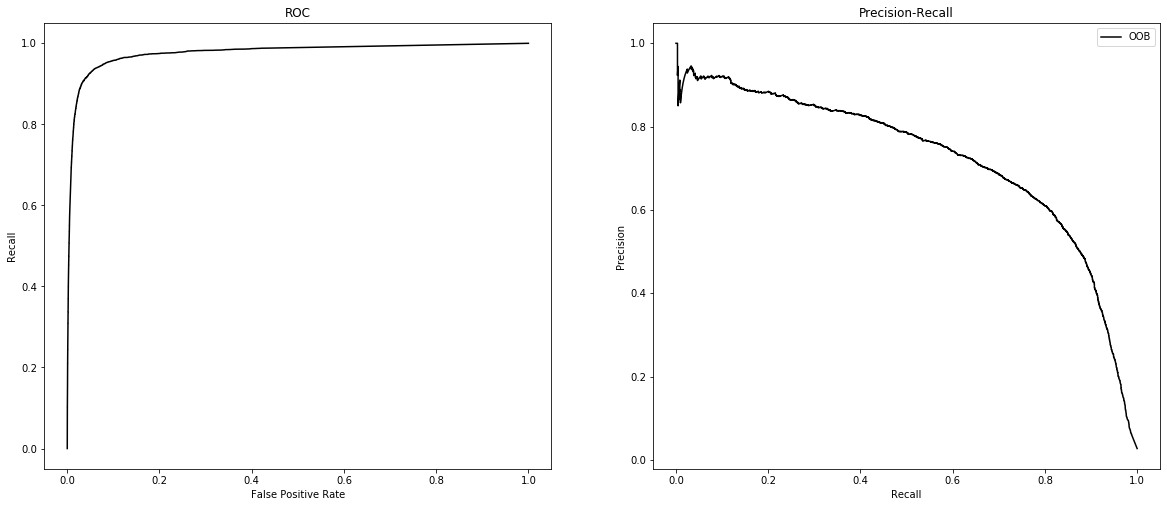

In [16]:
classifier = RandomForestClassifier(
        n_estimators = 2000, 
        oob_score = True, 
        class_weight="balanced", 
        random_state=237,
        n_jobs=4)

training_fields = ['conv_perim', 'conv_area',
                   'cc11', 'cc12', 'cc13',
                   'cc21', 'cc22', 'cc23',
                   'lifetime_s', 'deltaf', 'tau']

classifier.fit(labeled_sample[training_fields], labeled_sample['puff'])

plt.figure(figsize=(20,8.2))
ax1 = plt.subplot(121)
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('Recall')
ax1.set_title('ROC')
ax2 = plt.subplot(122)
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.set_title('Precision-Recall')
fpr, tpr , thresholds= roc_curve(labeled_sample['puff'], classifier.oob_decision_function_[:,1], pos_label = 1)
ax1.plot(fpr, tpr, label="OOB", color="k")
precision, recall, thresholds = precision_recall_curve(labeled_sample['puff'], classifier.oob_decision_function_[:,1],pos_label = 1)
ax2.plot(recall, precision, label="OOB", color="k")
plt.legend()

Distribution of predicted puffness for puffs and non-puffs:

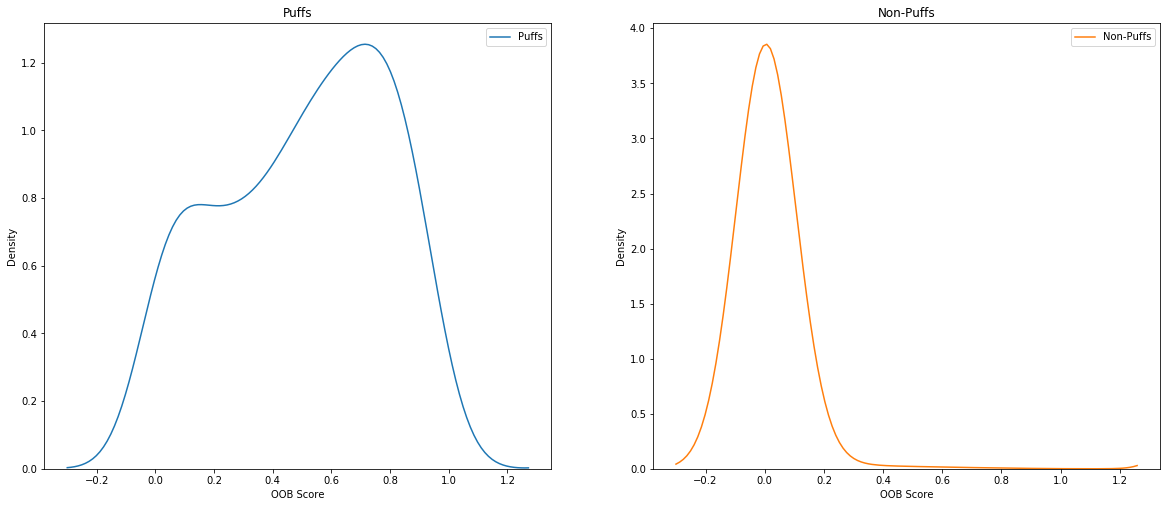

In [17]:
plt.figure(figsize=(20,8.2))
ax1 = plt.subplot(121)
ax1.set_xlabel('OOB Score')
ax1.set_ylabel('Density')
ax1.set_title('Puffs')
ax2 = plt.subplot(122)
ax2.set_xlabel('OOB Score')
ax2.set_ylabel('Density')
ax2.set_title('Non-Puffs')
sns.kdeplot(classifier.oob_decision_function_[labeled_sample['puff'] == 1, 1], label="Puffs", ax=ax1, bw=0.1)
sns.kdeplot(classifier.oob_decision_function_[labeled_sample['puff'] == 0, 1], label="Non-Puffs", ax=ax2, color="C1", bw=0.1)

That's not the worst! Do we improve if we restrict the lifetime of events? In this case, we're only including events that are greater than 10 frames in length.

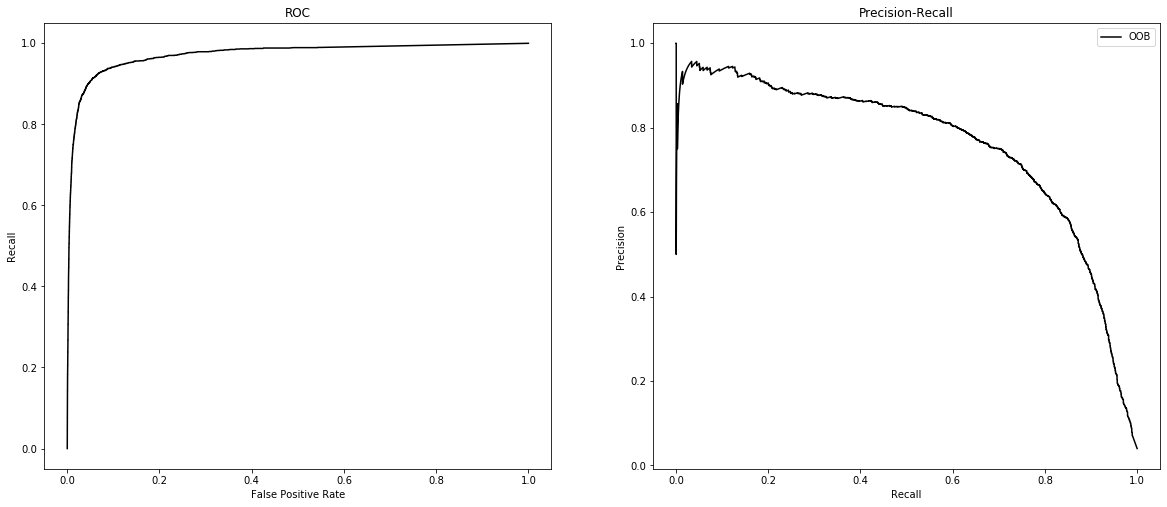

In [18]:
subsample = labeled_sample.loc[labeled_sample['lifetime_s'] >= 0.2, :]
classifier = RandomForestClassifier(
        n_estimators = 2000, 
        oob_score = True, 
        class_weight="balanced", 
        random_state=237,
        n_jobs=4)

training_fields = ['conv_perim', 'conv_area',
                   'cc11', 'cc12', 'cc13',
                   'cc21', 'cc22', 'cc23',
                   'lifetime_s', 'deltaf', 'tau']

classifier.fit(subsample[training_fields], subsample['puff'])

plt.figure(figsize=(20,8.2))
ax1 = plt.subplot(121)
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('Recall')
ax1.set_title('ROC')
ax2 = plt.subplot(122)
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.set_title('Precision-Recall')
fpr, tpr , thresholds= roc_curve(subsample['puff'], classifier.oob_decision_function_[:,1], pos_label = 1)
ax1.plot(fpr, tpr, label="OOB", color="k")
precision, recall, thresholds = precision_recall_curve(subsample['puff'], classifier.oob_decision_function_[:,1],pos_label = 1)
ax2.plot(recall, precision, label="OOB", color="k")
plt.legend()

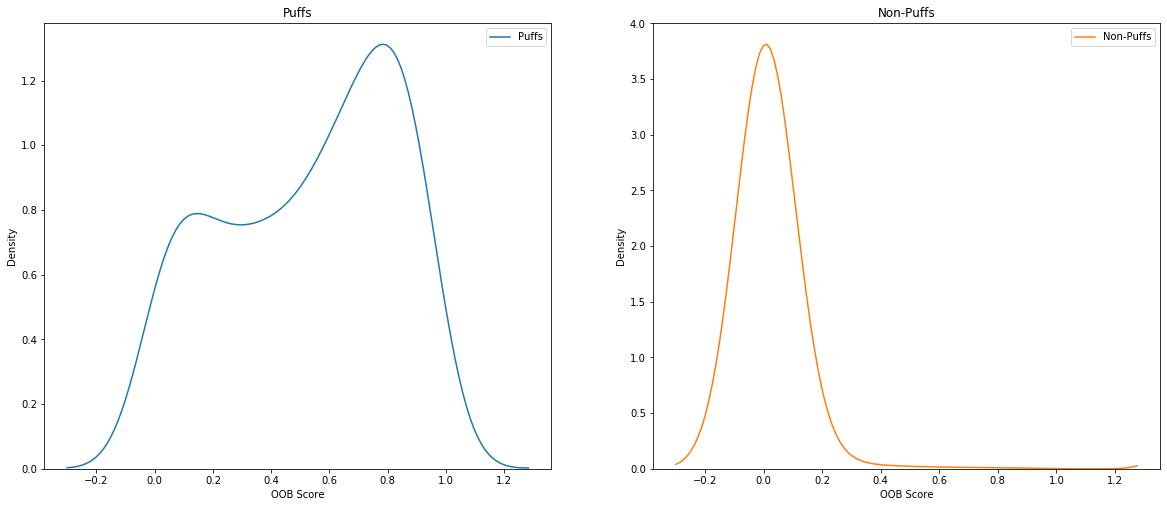

In [20]:
plt.figure(figsize=(20,8.2))
ax1 = plt.subplot(121)
ax1.set_xlabel('OOB Score')
ax1.set_ylabel('Density')
ax1.set_title('Puffs')
ax2 = plt.subplot(122)
ax2.set_xlabel('OOB Score')
ax2.set_ylabel('Density')
ax2.set_title('Non-Puffs')
sns.kdeplot(classifier.oob_decision_function_[subsample['puff'] == 1, 1], label="Puffs", ax=ax1, bw=0.1)
sns.kdeplot(classifier.oob_decision_function_[subsample['puff'] == 0, 1], label="Non-Puffs", ax=ax2, color="C1", bw=0.1)

Slight improvement, but not dramatic. What about the round-robin style classifier, trained on all data except one held-out cell?

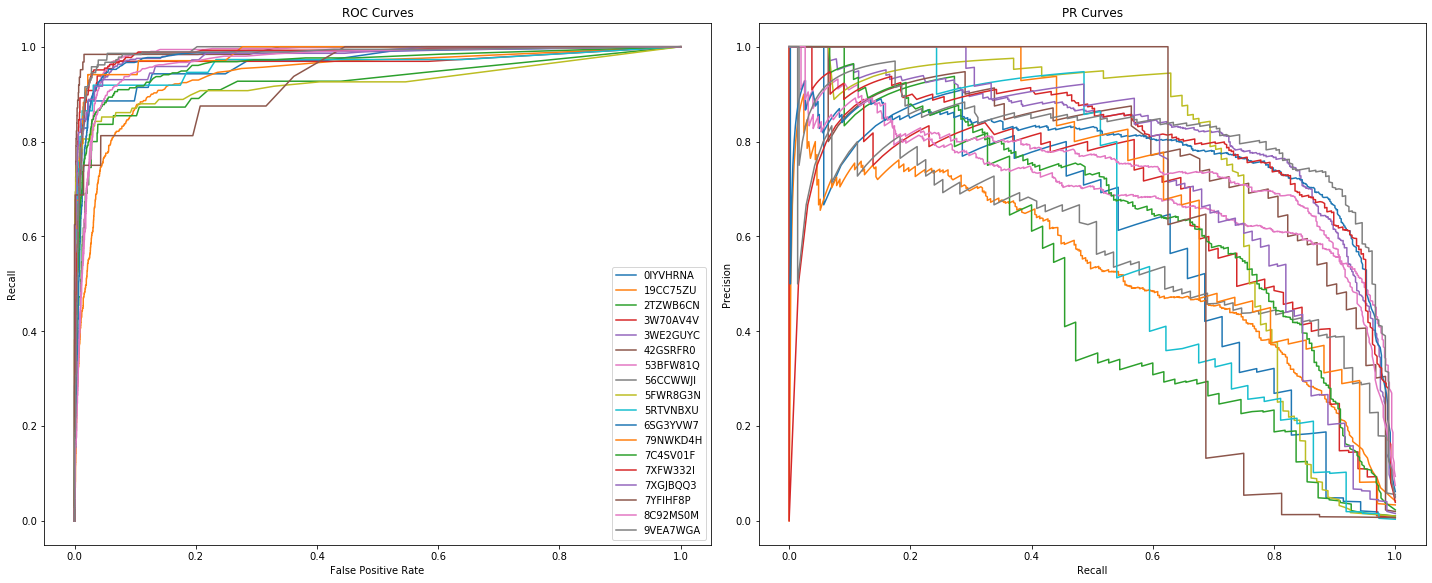

In [21]:
plt.figure(figsize=(20,8.2))
ax1 = plt.subplot(121)
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('Recall')
ax1.set_title('ROC Curves')
ax2 = plt.subplot(122)
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.set_title('PR Curves')

for cell in tqdm(np.unique(labeled_sample['cell'])):
    held_data = labeled_sample.loc[labeled_sample['cell'] == cell]
    train_data = labeled_sample.loc[labeled_sample['cell'] != cell]
    classifier = RandomForestClassifier(
        n_estimators = 2000, 
        oob_score = True, 
        class_weight="balanced", 
        random_state=237,
        n_jobs=4)
    classifier.fit(train_data[training_fields], train_data['puff'])
    probas_ = classifier.predict_proba(held_data[training_fields])
    fpr, tpr , thresholds= roc_curve(held_data['puff'], probas_[:,1], pos_label = 1)
    ax1.plot(fpr, tpr, label=cell)
    precision, recall, thresholds = precision_recall_curve(held_data['puff'], probas_[:,1],pos_label = 1)
    ax2.plot(recall, precision, label=cell)
    labeled_sample.loc[labeled_sample['cell'] == cell, 'proba'] = probas_[:,1]
                             
ax1.legend()
plt.tight_layout()
plt.show()

That performance is pretty variable, but decent on some cells!